# Data Preparation

### Imports

In [5]:
import investpy
import yfinance as yf
import pandas as pd
import numpy as np
import requests

## US companies ticket extraction

In [4]:
us_stocks = investpy.stocks.get_stocks(country='united states')
us_stocks.to_csv('companies/us_stocks.csv', index=False)
print(us_stocks.head())

         country             name               full_name          isin  \
0  united states           Boeing               Boeing Co  US0970231058   
1  united states   General Motors  General Motors Company  US37045V1008   
2  united states          Chevron            Chevron Corp  US1667641005   
3  united states        Citigroup           Citigroup Inc  US1729674242   
4  united states  Bank of America    Bank of America Corp  US0605051046   

  currency symbol  
0      USD     BA  
1      USD     GM  
2      USD    CVX  
3      USD      C  
4      USD    BAC  


## Stocks price extraction from yahoo finance

In [ ]:
tickers = us_stocks['symbol'].tolist()

for company in us_stocks.iterrows():
    ticker = company[1]["symbol"]
    try:
        ticker_obj = yf.Ticker(ticker)
        hist = ticker_obj.history(period="max")
        hist.to_csv(f"companies\\price\\{company[1]['name']}-{ticker}.csv", index=False)
        print(ticker)
    except Exception as e:
        print(e)

## Debt ratio extraction from FMP

In [ ]:
URL = "https://financialmodelingprep.com/api/v3/ratios/AAPL"

params = {
    'limit': '200',
    'apikey': '*'
}

for company in us_stocks.iterrows():
    ticker = company[1]["symbol"]
    
    try:
        response = requests.get(URL, params=params)
        json_res = response.json()
        company_debtR_history = {"Date": [], "DebtRatio": []}
        for year_data in json_res:
            if year_data['debtRatio'] != 0:
                company_debtR_history["Date"].append(year_data['date'])
                company_debtR_history["DebtRatio"].append(year_data['debtRatio'])
        
        company_df = pd.DataFrame(company_debtR_history)
        company_df.to_csv(f"companies/debt/{company[1]['name']}-{ticker}.csv", index=False)
        print(ticker)
    except Exception as e:
        print(e)

## Concatenate close price of a stock with debt ratio

In [14]:
def merge_with_flexible_dates(stocks, debt, day_range=5):
    merged_data = []
    
    for debt_row in debt.itertuples():
        debt_date = debt_row.Date
        
        # Try to find exact match in stocks
        stock_match = stocks[stocks['Date'] == debt_date]
        
        if stock_match.empty:
            # If no exact match, find stock data within the 5-day window
            stock_match = stocks[
                (stocks['Date'] >= debt_date - pd.Timedelta(days=day_range)) &
                (stocks['Date'] <= debt_date + pd.Timedelta(days=day_range))
            ]
        
        if not stock_match.empty:
            # Take the closest date (min difference)
            closest_stock = stock_match.iloc[0]
            combined_row = {
                'Date': debt_date,
                'Close': closest_stock['Close'],
                'Debt': debt_row.DebtRatio
            }
            merged_data.append(combined_row)
    
    return pd.DataFrame(merged_data)

In [ ]:
for company in us_stocks.iterrows():
    ticker = company[1]["symbol"]
    
    try:
        stocks = pd.read_csv(f"companies/price/{company[1]['name']}-{ticker}.csv")
        debt = pd.read_csv(f"companies/debt/{company[1]['name']}-{ticker}.csv")
        
        stocks['Date'] = pd.to_datetime(stocks['Date'], utc=True).dt.date
        debt['Date'] = pd.to_datetime(debt['Date']).dt.date
        debt = debt.sort_values(by='Date', ascending=True)
        
        combined_data = merge_with_flexible_dates(stocks, debt, day_range=2)
        only_close_debt = combined_data.dropna()
        
        if not only_close_debt.empty:
            print(ticker, company[1]['name'])
            only_close_debt.to_csv(f"companies/combined/{company[1]['name']}-{ticker}.csv", index=False)
    except Exception as e:
        print(e)

## Final concatenation

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
analysis_data = pd.DataFrame()
for company in us_stocks.iterrows():
    ticker = company[1]["symbol"]
    
    try:
        price_debt = pd.read_csv(f"companies/combined/{company[1]['name']}-{ticker}.csv")
        price_debt['Date'] = pd.to_datetime(price_debt['Date'])
        
        last_2_decades = price_debt[price_debt['Date'] >= pd.to_datetime("2003-01-01")]
        last_2_decades = last_2_decades.dropna()
        last_2_decades['Close_Percent_Change'] = last_2_decades['Close'].pct_change()
        
        ticker_obj = yf.Ticker(ticker)
        splits = pd.DataFrame(ticker_obj.splits)
        
        split_dates = []
        for split in splits.itertuples():
            split_dates.append(split[0])
        split_dates = pd.DataFrame({"Date": split_dates})
        
        split_dates['Date'] = pd.to_datetime(split_dates['Date'])
        split_dates['Date'] = split_dates['Date'].dt.tz_localize(None)
        splits_20_years = split_dates[split_dates['Date'] >= pd.to_datetime("2003-01-01")]
        
        if len(last_2_decades) >= 20 and len(splits_20_years) == 0:
            final = last_2_decades
            
            data_from_2003 = final[final['Date'] >= pd.to_datetime("2003-01-01")]
            first_price_2003 = data_from_2003['Close'].iloc[0]
            final['Close'] = final['Close'] / first_price_2003
            
            final['Company'] = company[1]['name']
            
            if analysis_data.empty:
                analysis_data = final
            else:
                analysis_data = pd.concat([analysis_data, final], axis=0)
            
            print(ticker, company[1]['name'])
    
    except Exception as e:
        print(e)

analysis_data.to_csv("companies/analysis_data.csv", index=False)

# Analysis

## Basic scatter for 4 random companies

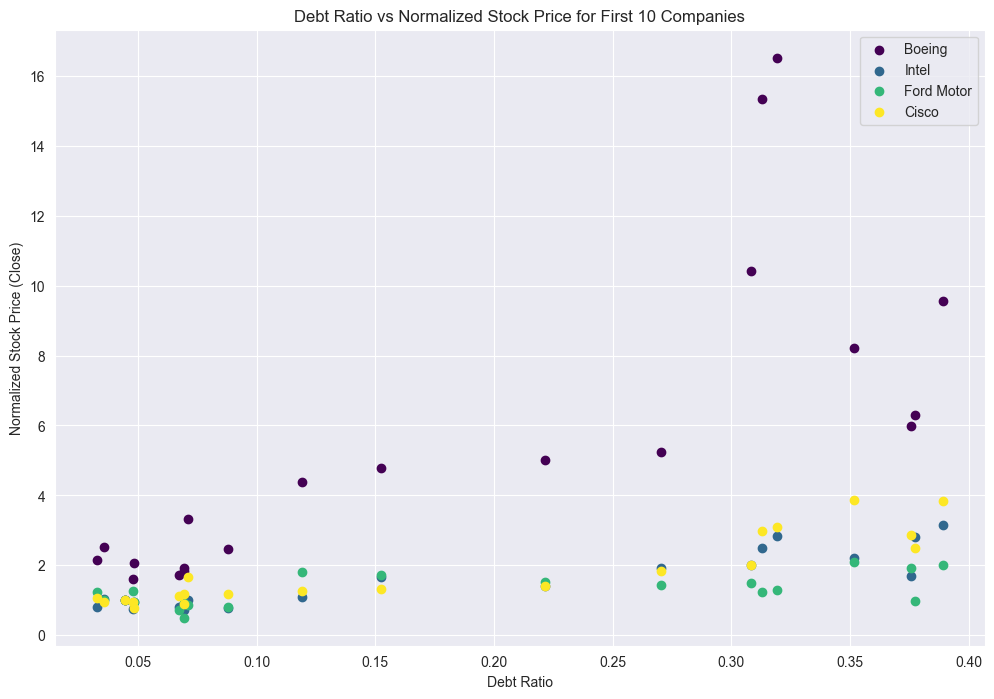

In [7]:
import matplotlib.pyplot as plt

analysis_data = pd.read_csv("companies/analysis_data.csv")

unique_companies = analysis_data['Company'].unique()[:4]  # Get the first 10 unique companies
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_companies)))  # Generate colors

plt.figure(figsize=(12, 8))

# Step 3: Scatter Plot
for i, company in enumerate(unique_companies):
    company_data = analysis_data[analysis_data['Company'] == company]
    plt.scatter(company_data['Debt'], company_data['Close'], 
                color=colors[i], label=company)

# Step 4: Customize the plot
plt.title('Debt Ratio vs Normalized Stock Price for First 10 Companies')
plt.xlabel('Debt Ratio')
plt.ylabel('Normalized Stock Price (Close)')
plt.legend()
plt.grid(True)
plt.show()

## Regression analysis

In [36]:
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [32]:
analysis_data = analysis_data.dropna()

df = analysis_data.sort_values('Date')
df['Date'] = pd.to_datetime(df['Date'])

df['Time'] = (df['Date'] - df['Date'].min()).dt.days

df = df.dropna()

grouped_companies = df.groupby('Company')

In [33]:
results = []

for company, group in grouped_companies:

    # Time-based model (without Debt)
    X_time = group[['Time', 'Close_Percent_Change']]
    
    # Time + Debt model
    X_time_debt = group[['Time', 'Close_Percent_Change', 'Debt']]
    
    # Actual values
    y = group['Close']
    
    # Split data (Time-based model)
    X_train_time, X_test_time, y_train, y_test = train_test_split(X_time, y, test_size=0.2, random_state=42)
    
    # Split data (Time + Debt model)
    X_train_time_debt, X_test_time_debt, y_train_debt, y_test_debt = train_test_split(X_time_debt, y, test_size=0.2, random_state=42)
    
    # Time-based Model (without debt)
    model_time = LinearRegression()
    model_time.fit(X_train_time, y_train)
    y_pred_time = model_time.predict(X_test_time)
    
    mse_time = mean_squared_error(y_test, y_pred_time)
    r2_time = r2_score(y_test, y_pred_time)

    # Time + Debt Model (with debt)
    model_time_debt = LinearRegression()
    model_time_debt.fit(X_train_time_debt, y_train_debt)
    y_pred_time_debt = model_time_debt.predict(X_test_time_debt)
    
    mse_time_debt = mean_squared_error(y_test_debt, y_pred_time_debt)
    r2_time_debt = r2_score(y_test_debt, y_pred_time_debt)
    
    # Store the results for this company
    results.append({
        'Company': company,
        'MSE_Time': mse_time,
        'R2_Time': r2_time,
        'MSE_Time_Debt': mse_time_debt,
        'R2_Time_Debt': r2_time_debt
    })

In [34]:
results_df = pd.DataFrame(results)

results_df.head()

,Company,MSE_Time,R2_Time,MSE_Time_Debt,R2_Time_Debt
0,1-800 FLOWERS.COM,1.980127,-0.156740,1.348132,0.212455
1,8x8,25.270798,0.401286,20.615548,0.511578
2,AAR,2.996837,0.061889,3.664258,-0.147037
3,AB Electrolux,0.084810,0.859839,0.101314,0.832564
4,ABM Industries,0.209584,0.894477,0.033666,0.983050


In [37]:
def f_test(mse_reduced, mse_full, n, k_reduced, k_full):
    numerator = (mse_reduced - mse_full) / (k_full - k_reduced)
    denominator = mse_full / (n - k_full)
    return numerator / denominator

n = 20
k_reduced = 2
k_full = 3

results_df['F_statistic'] = results_df.apply(lambda row: f_test(row['MSE_Time'], row['MSE_Time_Debt'], n, k_reduced, k_full), axis=1)

results_df['P_value'] = results_df['F_statistic'].apply(lambda x: stats.f.sf(x, k_full - k_reduced, n - k_full))

results_df[['Company', 'P_value']]

,Company,P_value
0,1-800 FLOWERS.COM,1.172286e-02
1,8x8,6.668755e-02
2,AAR,1.000000e+00
3,AB Electrolux,1.000000e+00
4,ABM Industries,3.661107e-08
...,...,...
842,YPF Sociedad Anonima,9.711487e-02
843,Yamaha DRC,6.930841e-03
844,Zions,1.826633e-10
845,Zurich Insurance Group,1.208662e-02


In [38]:
results_df[results_df['P_value'] < 0.05][['Company', 'P_value']]

,Company,P_value
0,1-800 FLOWERS.COM,1.172286e-02
4,ABM Industries,3.661107e-08
5,ACADIA,3.506727e-02
7,AMD,1.363578e-02
8,AMN Healthcare Services,1.643964e-03
...,...,...
841,Xcel Energy,5.838227e-05
843,Yamaha DRC,6.930841e-03
844,Zions,1.826633e-10
845,Zurich Insurance Group,1.208662e-02


In [39]:
results_df['P_value'].mean()

0.3977776062149023

## Covariance analysis

In [11]:
analysis_data = pd.read_csv("companies/analysis_data.csv")

def calculate_covariance(group):
    return group[['Close', 'Debt']].cov().iloc[0, 1]

covariance_table = analysis_data.groupby('Company').apply(calculate_covariance).reset_index()
covariance_table.columns = ['Company', 'price_ratio_covariance']

covariance_table

C:\Users\Danila\AppData\Local\Temp\ipykernel_22816\702562892.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  covariance_table = analysis_data.groupby('Company').apply(calculate_covariance).reset_index()


,Company,price_ratio_covariance
0,1-800 FLOWERS.COM,0.078226
1,8x8,0.457738
2,AAR,0.191856
3,AB Electrolux,0.055100
4,ABM Industries,0.156988
...,...,...
842,YPF Sociedad Anonima,-0.080154
843,Yamaha DRC,0.129992
844,Zions,0.013791
845,Zurich Insurance Group,0.921701


In [56]:
significant_table = covariance_table[(covariance_table['price_ratio_covariance'] < -0.1) | (covariance_table['price_ratio_covariance'] > 0.1)]
significant_table

,Company,price_ratio_covariance
1,8x8,0.457738
2,AAR,0.191856
4,ABM Industries,0.156988
5,ACADIA,0.185380
6,AGCO,0.233167
...,...,...
839,Worthington Industries,0.386847
840,Wynn Resorts,0.199423
841,Xcel Energy,0.384612
843,Yamaha DRC,0.129992


In [61]:
# model improvement and relatively high covariance
merged_data = pd.merge(covariance_table, results_df[results_df['P_value'] < 0.05][['Company', 'P_value']], on='Company', how='inner')
print(merged_data['price_ratio_covariance'].mean())
merged_data

0.28448033731948247


,Company,price_ratio_covariance,P_value
0,1-800 FLOWERS.COM,0.078226,1.172286e-02
1,ABM Industries,0.156988,3.661107e-08
2,ACADIA,0.185380,3.506727e-02
3,AMD,0.290524,1.363578e-02
4,AMN Healthcare Services,0.245535,1.643964e-03
...,...,...,...
400,Xcel Energy,0.384612,5.838227e-05
401,Yamaha DRC,0.129992,6.930841e-03
402,Zions,0.013791,1.826633e-10
403,Zurich Insurance Group,0.921701,1.208662e-02


In [62]:
import statsmodels.api as sm


price_change_results = []
needed_companies = pd.merge(df, merged_data, on='Company', how='inner')
for company, group in grouped_companies:
    X = group['Debt']
    y = group['Close']

    model = sm.OLS(y, X)
    results = model.fit()

    slope = results.params['Debt']

    price_change_for_1_percent = slope * 0.01  # 1% change in debt ratio

    price_change_results.append({
        'Company': company,
        'Slope (per unit)': slope,
        'Price Change for 1% Debt Ratio Change': price_change_for_1_percent
    })

price_change_df = pd.DataFrame(price_change_results)


price_change_df

,Company,Slope (per unit),Price Change for 1% Debt Ratio Change
0,1-800 FLOWERS.COM,5.534154,0.055342
1,8x8,26.637292,0.266373
2,AAR,16.860614,0.168606
3,AB Electrolux,7.010692,0.070107
4,ABM Industries,12.279703,0.122797
...,...,...,...
842,YPF Sociedad Anonima,4.308954,0.043090
843,Yamaha DRC,8.206660,0.082067
844,Zions,3.372191,0.033722
845,Zurich Insurance Group,46.038507,0.460385


In [63]:
# average change in stock price for 1 percent change in debt ratio
price_change_df['Price Change for 1% Debt Ratio Change'].mean() * 100

18.57303909291291

In [64]:
needed_companies = pd.merge(price_change_df, merged_data, on='Company', how='inner')
needed_companies['Price Change for 1% Debt Ratio Change'].mean() * 100

17.89495545231014

In [65]:
needed_companies = pd.merge(price_change_df, results_df[results_df['P_value'] >= 0.05][['Company', 'P_value']], on='Company', how='inner')
needed_companies['Price Change for 1% Debt Ratio Change'].mean() * 100

19.19436007581816

## Correlation analysis 

In [66]:
correlation_results = pd.DataFrame(columns=['Company', 'Correlation'])

correlation_results = []

for company, group in analysis_data.groupby('Company'):
    group = group.dropna(subset=['Debt', 'Close'])
    correlation = group['Debt'].corr(group['Close'])
    correlation_results.append({'Company': company, 'Correlation': correlation})

correlation_results_df = pd.DataFrame(correlation_results)

print("All companies with counted correlation: ", len(correlation_results_df))
correlation_results_df

All companies with counted correlation:  847


,Company,Correlation
0,1-800 FLOWERS.COM,0.644178
1,8x8,0.684363
2,AAR,0.734995
3,AB Electrolux,0.623852
4,ABM Industries,0.968201
...,...,...
842,YPF Sociedad Anonima,-0.773401
843,Yamaha DRC,0.880036
844,Zions,0.292352
845,Zurich Insurance Group,0.911552


In [68]:
only_strong_corr = correlation_results_df[(correlation_results_df['Correlation'] > 0.5) | (correlation_results_df['Correlation'] < -0.5)]
only_strong_corr

,Company,Correlation
0,1-800 FLOWERS.COM,0.644178
1,8x8,0.684363
2,AAR,0.734995
3,AB Electrolux,0.623852
4,ABM Industries,0.968201
...,...,...
841,Xcel Energy,0.951820
842,YPF Sociedad Anonima,-0.773401
843,Yamaha DRC,0.880036
845,Zurich Insurance Group,0.911552


In [45]:
from scipy import stats

def calculate_correlation_significance(r, n):
    # Calculate t-statistic
    t = r * ((n - 2) ** 0.5) / ((1 - r ** 2) ** 0.5)
    # Calculate p-value
    p_value = 2 * (1 - stats.t.cdf(abs(t), df=n - 2))  # Two-tailed test
    return p_value

correlation_results_df['p_value'] = correlation_results_df.apply(lambda row: calculate_correlation_significance(row['Correlation'], len(analysis_data[analysis_data['Company'] == row['Company']])), axis=1)

significant_correlations = correlation_results_df[correlation_results_df['p_value'] < 0.05]

significant_correlations

,Company,Correlation,p_value
0,1-800 FLOWERS.COM,0.634649,1.998777e-03
1,8x8,0.697409,4.412514e-04
2,AAR,0.750695,8.830121e-05
3,AB Electrolux,0.644519,1.611115e-03
4,ABM Industries,0.967208,9.148238e-13
...,...,...,...
841,Xcel Energy,0.954326,2.025224e-11
842,YPF Sociedad Anonima,-0.702525,3.837832e-04
843,Yamaha DRC,0.878915,1.579297e-07
845,Zurich Insurance Group,0.915771,5.825338e-09


In [46]:
combined_corr_df = pd.merge(significant_correlations, only_strong_corr, on='Company', how='inner')
combined_corr_df

,Company,Correlation_x,p_value,Correlation_y
0,AAR,0.750695,8.830121e-05,0.750695
1,ABM Industries,0.967208,9.148238e-13,0.967208
2,ACADIA,0.719115,3.527656e-04,0.719115
3,AGCO,0.834052,2.625045e-06,0.834052
4,AMD,0.738019,1.339425e-04,0.738019
...,...,...,...,...
492,Worthington Industries,0.925726,1.834775e-09,0.925726
493,Xcel Energy,0.954326,2.025224e-11,0.954326
494,YPF Sociedad Anonima,-0.702525,3.837832e-04,-0.702525
495,Yamaha DRC,0.878915,1.579297e-07,0.878915


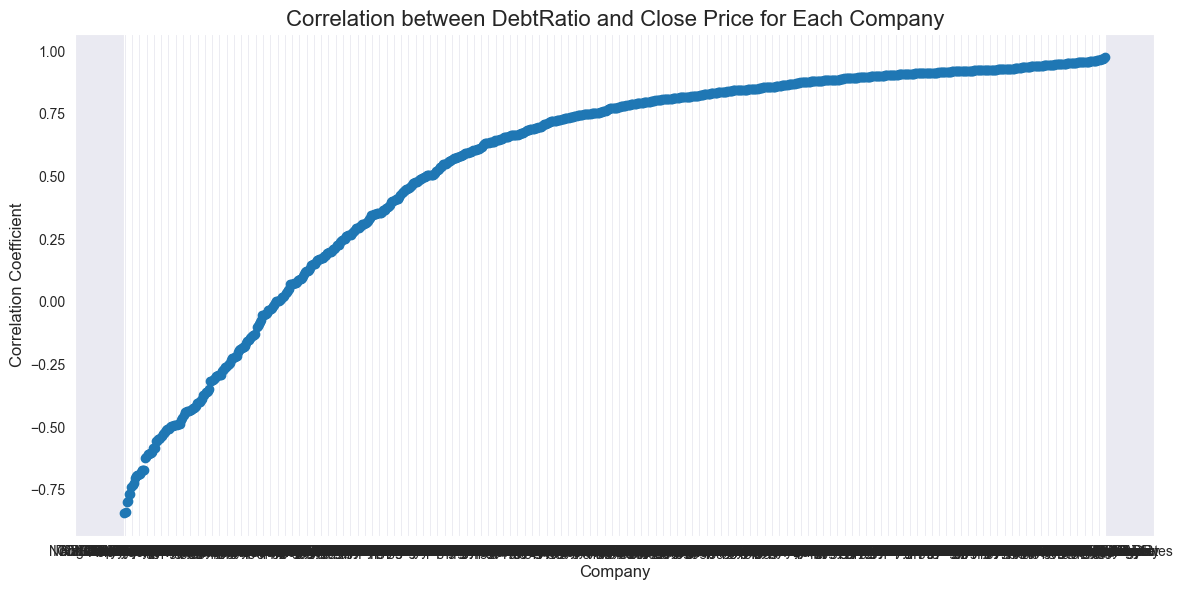

In [47]:
import seaborn as sns

sorted_correlation_df = correlation_results_df.sort_values(by='Correlation', ascending=True)

plt.figure(figsize=(12, 6))

# Create a bar plot
plt.scatter(sorted_correlation_df["Company"], sorted_correlation_df["Correlation"])

# Set titles and labels
plt.title('Correlation between DebtRatio and Close Price for Each Company', fontsize=16)
plt.xlabel('Company', fontsize=12)
plt.ylabel('Correlation Coefficient', fontsize=12)

# Show grid lines
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()